# Лекция 5.1 "Монады. Часть 1"

__План:__
  - Определение и описание
    - Основные примеры из _Haskell_
      - Монада _```Maybe```_
      - Монада _```Identity```_
      - Монада _```Either```_
      - Монада _```List```_
  - Monad composition
  - Monad zen
  - Joining monads
  - Trying to make a monad
  - Functions on monads
  - Monad laws
  - Equational reasoning
    -  Доказательство законов для _`Maybe`_
  - List monad nondeterminism

## Определение и описание

__def:__ __Монада__ - это особый тип данных в функциональных языках программирования, для которого возможно задать императивную последовательность выполнения некоторых операций над хранимыми значениями.  
Монады позволяют задавать последовательность выполнения операций, производить операции с побочными эффектами и другие действия, которые сложно или вовсе невозможно реализовать в функциональной парадигме программирования другими способами.  
Более простым языком: это обертка над вычислениями.

```
class Monad m where   -- m :: * -> *
    return :: a -> m a                  -- return
    (>>=)  :: m a -> (a -> m b) -> m b  -- bind
```

### Основные примеры

#### Монада _```Maybe```_

Монада _```Maybe```_:

```
data Maybe a = Nothing | Just a

instance Monad Maybe where
    return :: a -> Maybe a
    return = Just
  
    (>>=) :: Maybe a -> (a -> Maybe b) -> Maybe b
    Nothing >>= _ = Nothing
    Just a  >>= f = f a

ghci> Just 5 >>= (\x -> Just $ x + 3)
Just 8
ghci> Just 5 >>= (\x -> return $ x + 3)
Just 8
ghci> Nothing >>= (\x -> return $ x + 3)
Nothing
ghci> Just 3 >>= \x -> Just 4 >>= \y -> Just (x + y)
Just 7
```

Наивная реализация пары из _```Maybe```_:

```
maybePair :: Maybe a -> Maybe b -> Maybe (a, b)    -- naive implementation
maybePair Nothing  _        = Nothing
maybePair _        Nothing  = Nothing
maybePair (Just a) (Just b) = Just (a, b)
```

Реализация пары из _```Maybe```_ с помощью Монад:

```
maybePair :: Maybe a -> Maybe b -> Maybe (a, b)    -- monadic implementation
maybePair ma mb = ma >>= \a -> mb >>= \b -> Just (a, b)
```

Общая реализация пары Монад:

```
monadPair :: Monad m => m a -> m b -> m (a, b)    -- polymorphic implementation
monadPair ma mb = ma >>= \a -> mb >>= \b -> return (a, b)
```

#### Монада _```Identity```_

Монада _```Identity```_:

```
newtype Identity a = Identity { runIdentity :: a }

instance Monad Identity where
    return  = Identity
    i >>= f = ...
```

#### Монада _```Either```_

Монада _```Either```_:

```
instance Monad (Either e) where ...  -- Either a :: * -> *
    return :: a -> Either e a
    return = Right

    (>>=) :: Either e a -> (a -> Either e b) -> Either e b
    Left e  >>= _ = Left e
    Right a >>= f = f a
```

Пример использования:

```
data ValidationError = InvalidStrip | TooBigLength

stripUsername :: String -> Either ValidationError String
stripUsername ""          = Left InvalidStrip
stripUsername name@(n:ns) = case isSpace n || isPunctuation n of
    True  -> stripUsername ns
    False -> Right name

validateLength :: Int -> String -> Either ValidationError String
validateLength maxLen s = if length s > maxLen
                          then Left TooBigLength
                          else Right s

mkUser :: String -> Either ValidationError Username
mkUser name = stripUsername name >>= validateLength 15 >>= return . Username


ghci> mkUser "   "
Left InvalidStrip
ghci> mkUser " ...  I Am The Greatest Hero Of All Times ... "
Left TooBigLength
ghci> mkUser "JustSenia..."
Right ( Username "JustSenia..." )
```

#### Монада _```List```_

Описание: 

```
instance Monad [] where
    return :: a -> [a]
    return x = [x]  -- using bender-operator: return = (:[])
    
    (>>=) :: [a] -> (a -> [b]) -> [b]
    l >>= f  = concat (map f l)  -- or using concatMap
```

Примеры:

```
ghci> [10, 5, 7] >>= replicate 3
[10, 10, 10, 5, 5, 5, 7, 7, 7]

surround :: a -> a -> [a] -> [a]
surround '(' ')' "abacaba" = "(a)(b)(a)(c)(a)(b)(a)"

ghci> [1..5] >>= \x -> replicate x x
[1,2,2,3,3,3,4,4,4,4,5,5,5,5,5]

ghci> let step x = [x - 1, x + 1]
ghci> [0] >>= step
[-1,1]
ghci> [0] >>= step >>= step
[-2,0,0,2]
ghci> [0] >>= step >>= step >>= step
[-3,-1,-1,1,-1,1,1,3]
ghci> [0] >>= step >>= step >>= step >>= step
[-4,-2,-2,0,-2,0,0,2,-2,0,0,2,0,2,2,4]
```

## Monad composition

__Композиция монад__

```
(.)   ::            (b ->   c) -> (a ->   b) -> a ->   c

-- Аналог (.) для композиции монад --
(<=<) :: Monad m => (b -> m c) -> (a -> m b) -> a -> m c

(>=>) :: Monad m => (a -> m b) -> (b -> m c) -> a -> m c

m >>= (f >=> g) ≡ m >>= f >>= g
m >>= (f <=< g) ≡ m >>= g >>= f

-- associativity --
(f >=> g) >=> h ≡ f >=> (g >=> h)
```

Примеры:

```
-- Пример 1 --
safeTail :: [a] -> Maybe [a]
safeInit :: [a] -> Maybe [a]

safeStrip :: [a] -> Maybe [a]
safeStrip = safeTail >=> safeInit

-- Пример 2 --
stripUsername  :: String -> Maybe String
validateLength :: Int -> String -> Maybe String

mkUser :: String -> Maybe Username
mkUser name = stripUsername name >>= validateLength 15 >>= Just . Username
mkUser      = stripUsername      >=> validateLength 15 >=> Just . Username
```

## Monad zen

__Monad zen (then)__:

```
(>>) :: Monad m => m a -> m b -> m b  -- then
m >> k = m >>= \_ -> k
```

Примеры:

```
ghci> Nothing >> Just 5
Nothing

ghci> [True,False] >> [1,2,3]
[1,2,3,1,2,3]
```

__```guard```__ is a polymorphic function but for lists looks like this:

```
guard :: Bool -> [()]
guard True  = [()]
guard False = [] -- return mzero (neutral element)

ghci> [True,False,True] >> [1,2]
[1,2,1,2,1,2]
ghci> [True,False,True] >>= \b -> guard b >> [1,2]
[1,2,1,2]
```

## Joining monads

Объединение монад:

```
join :: Monad m => m (m a) -> m a
```

Примеры:

```
ghci> join [[3, 4], [7, 10]]
[3, 4, 7, 10]

ghci> join Just (Just 3)
Just 3
```

__Тип вложенной__ монады должен соответствовать __типу внешней__:

```
ghci> join $ Just [1,2,3]

    • Couldn't match type ‘[]’ with ‘Maybe’
      Expected type: Maybe (Maybe a)
        Actual type: Maybe [a]
    • In the second argument of ‘($)’, namely ‘Just [1, 2, 3]’
      In the expression: join $ Just [1, 2, 3]
      In an equation for ‘it’: it = join $ Just [1, 2, 3]
```

__Вопрос:__ Можем ли мы написать общую имплементацию для функции _```extract```_??

```
extract :: Monad m => m a -> a    -- ??
```

_Ответ:_ Нет, так как в общем случае непонятно, что мы собираемся извлекать. __Но__ для частной монады _можно_. 

## Trying to make a monad

Попробуем написать _`instance`_ для какого-нибудь простого типа:

```
data Repeat a = Empty | Single a | Repeat a

instance Monad Repeat where
    return :: a -> Repeat a
    return = Single

    (>>=) :: Repeat a -> (a -> Repeat b) -> Repeat b
    Empty    >>= _ = Empty
    Single a >>= f = f a
    Repeat a >>= f = f a >>= f -- не сойдутся типы
```

__Вопрос:__ what's the problem with Repeat?  
_Ответ:_не сойдутся типы в _`Repeat a >>= f`_, так как _`f a`_ вернёт тип _`Repeat b`_ и применить функцию _`f`_ мы уже не сможем :(( 

## Functions on monads

_`LiftM`_ - "поднять вычисления", т. е. вычислить функцию внутри монады. Очень похожа на _`fmap`_.

Пакет [Control.Monad](https://hackage.haskell.org/package/base-4.10.0.0/docs/Control-Monad.html)

```
liftM :: Monad m => (a -> b) -> m a -> m b
```

Примеры:

```
-- Пример 1 --
ghci> liftM (+1) (Just 3)
Just 4
ghci> liftM (+1) Nothing
Nothing

-- Пример 2 --
liftM2 :: Monad m => (a -> b -> c) -> m a -> m b -> m c

ghci> liftM2 (+) (Just 1) (Just 2)
Just 3

-- Пример 3 --
ghci> let monadPair = liftM2 (,)
monadPair :: Monad m => m a -> m b -> m (a, b)

ghci> monadPair (Just 3) (Just 5)
Just (3,5)
ghci> monadPair (Just 3) Nothing
Nothing
ghci> monadPair [1..3] [5,10]
[(1,5), (1,10), (2,5), (2,10), (3,5), (3,10)]
```

Пакет [Control.Monad.Extra](https://hackage.haskell.org/package/extra-1.6/docs/Control-Monad-Extra.html)

```
(||^) :: Monad m => m Bool -> m Bool -> m Bool  -- lazy monadic ||
(&&^) :: Monad m => m Bool -> m Bool -> m Bool  -- lazy monadic &&

ghci> Just False ||^ Just True
Just True
ghci> Just False &&^ Just True
Just False
ghci> Just False &&^ Nothing
Just False
ghci> Just True  &&^ Nothing
Nothing
ghci> Nothing    &&^ Just True
Nothing
```


## Monad laws

1. Закон левой единицы

```
return a >>= f  ≡ f a                      -- left identity
```

2. Закон правой единицы

```
m >>= return    ≡ m                        -- right identity
```

3. Закон ассоциативности

```
(m >>= f) >>= g ≡ m >>= (\x -> f x >>= g)  -- associativity
```

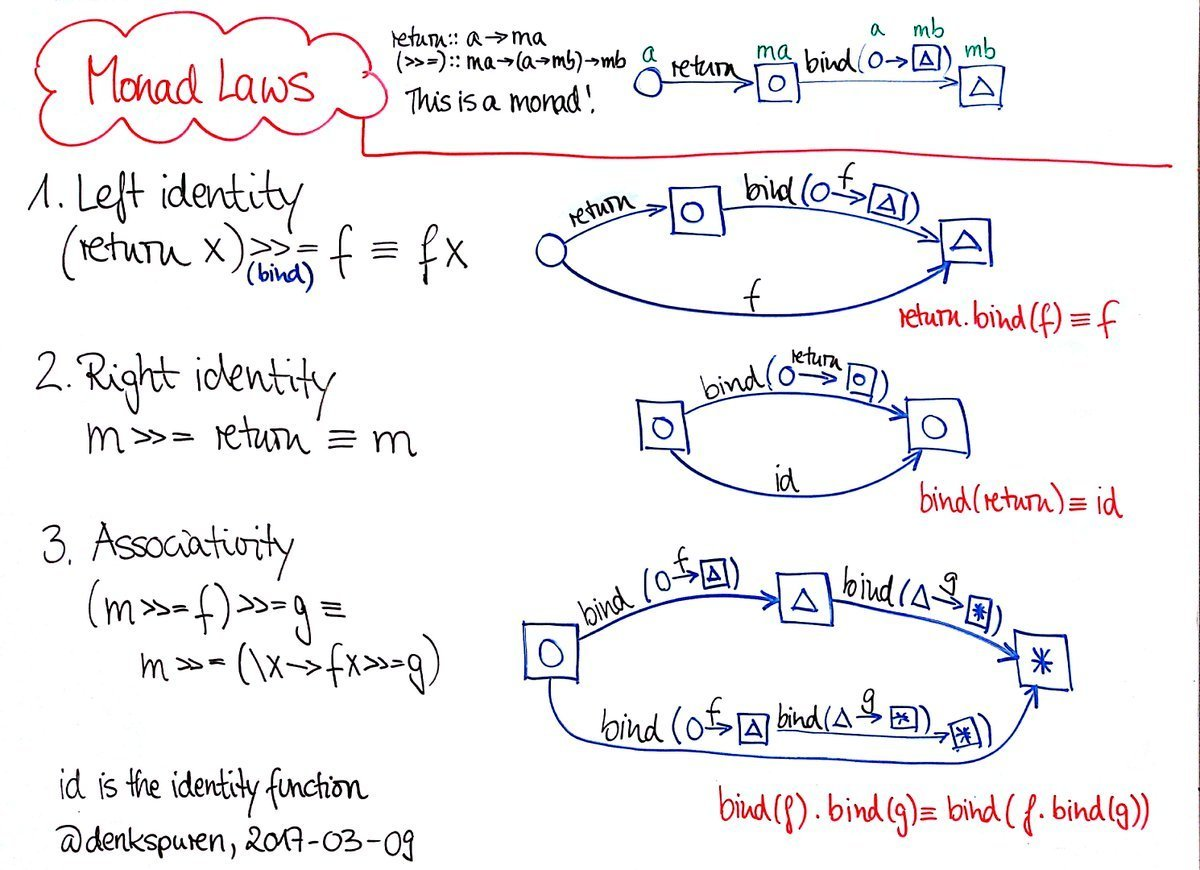

In [ ]:
import IPython

IPython.display.Image('drive/MyDrive/Exam/img/monad2.jpg')

## Equational reasoning

To prove one thing equals to another you can use so-called ***Equational reasoning*** technique — _step-by-step transformation_

Пример:

```
foldr :: (a -> b -> b) -> b -> [a] -> b
foldr _ z []     =  z                   -- (1) case
foldr f z (x:xs) =  x `f` foldr f z xs  -- (2) case

foldr (+) 0 [1,2,3] ≡ 1 + foldr (+) 0 [2,3]           -- using (2)
                    ≡ 1 + (2 + foldr (+) 0 [3])       -- using (2)
                    ≡ 1 + (2 + (3 + foldr (+) 0 []))  -- using (2)
                    ≡ 1 + (2 + (3 + 0))               -- using (1)
                    ≡ 1 + (2 + 3)                     -- definition of (+)
                    ≡ 1 + 5                           -- definition of (+)
                    ≡ 6                               -- definition of (+)
```

Докажем законы монад для простой монады _`Maybe`_:

```
instance Monad Maybe where
    return = Just            -- (1): return
  
    Nothing >>= _ = Nothing  -- (2): bind-Nothing
    Just a  >>= f = f a      -- (3): bind-Just

-- 1. Left identity: return a >>= f ≡ f a
return a >>= f ≡ Just a >>= f  -- (1): return
               ≡ f a           -- (3): bind-Just

-- 2. Right identity: m >>= return ≡ m
Just a >>= return 
    ≡ return a  -- (3): bind-Just
    ≡ Just a    -- (1): return

-- 3. Associativity: (m >>= f) >>= g ≡ m >>= (\x -> f x >>= g)
    -- m == Nothing
      1. (Nothing >>= f) >>= g
          ≡ Nothing >>= g -- (2): bind-Nothing
          ≡ Nothing       -- (2): bind-Nothing
      2. Nothing >>= (\x -> f x >>= g)
          ≡ Nothing       -- (2): bind-Nothing

    -- m == Just a
      1. (Just a >>= f) >>= g 
          ≡ f a >>= g  -- (3): bind-Just
      2. Just a >>= (\x -> f x >>= g)
          ≡ (\x -> f x >>= g) a  -- (3): bind-Just
          ≡ f a >>= g            -- function application
```

## List monad nondeterminism

Множество подмножеств списка:

```
powerset :: [a] -> [[a]]  -- all subsets of given list
powerset []     = [[]]
powerset (x:xs) = powerset xs >>= \set -> [set, x:set]

ghci> powerset [1,2,3]
[ [], [ 1 ], [ 2 ], [ 1, 2 ], [ 3 ], [ 1, 3 ], [ 2, 3 ], [ 1, 2, 3 ] ] 
```

Проэмулируем распределение с честной и нечестной монетками:

```
data CoinType = Fair | Biased deriving (Show)
data Coin     = Head | Tail   deriving (Show, Eq)

toss :: CoinType -> [Coin]
toss Fair   = [Head, Tail]
toss Biased = [Head, Head]

pick :: [CoinType]
pick = [Fair, Biased]

experiment :: [CoinType]
experiment =
  pick      >>= \coin   ->   -- Pick a coin at random
  toss coin >>= \result ->   -- Toss it, to get a result
  guard (result == Head) >>  -- We only care about results that come up Heads
  return coin                -- Return which coin was used in this case
-- experiment = [coin | coin <- pick, result <- toss coin, result == Head] -- Синаксический сахар

ghci> experiment
[Biased, Biased, Fair]  -- 2/3 chance for Biased and 1/3 chance for Fair
```